# Aerial Cactus Prediction

## Business Problem  
* classifier capable of predicting whether an images contains a cactus.

## 1.reading csv

In [8]:
import pandas as pd
train=pd.read_csv("train.csv")

In [9]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [10]:
cd train

/content/train


<i><b>removing the image from the folder </b></i>

In [11]:
#path = "/train"
import glob
text_files = glob.glob("0014d7a11e90b62848904c1418fc8cf2.jpg", recursive = True)

print(text_files)

['0014d7a11e90b62848904c1418fc8cf2.jpg']


In [12]:
import glob
for id in train['id']:
    text_files = glob.glob(id, recursive = True)
    if not text_files:
        print(id)

In [13]:
file_not_found=train.apply(lambda row: row.astype(str).str.contains('3799ac842a5e50a6a783b9f611b59039.jpg').any(), axis=1)

In [14]:
train.loc[file_not_found]

,id,has_cactus
3960,3799ac842a5e50a6a783b9f611b59039.jpg,1


In [15]:
train = train.drop(3960)

In [16]:
has_cactus=train['has_cactus'].value_counts()
print(has_cactus)

1    13135
0     4364
Name: has_cactus, dtype: int64


In [17]:
#checking the size of image
import numpy as np
import cv2
for _id in train["id"]:
    img = cv2.imread(_id)
    print(img.shape)
    break

(32, 32, 3)


## 2.CNN Models

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
datagen=ImageDataGenerator(rescale=1/255,validation_split=0.30)

In [20]:
train

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [21]:
train["has_cactus"]= train["has_cactus"].apply(str)

In [22]:
bs = 64

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    x_col = "id",
    y_col = "has_cactus",
    subset = "training",
    batch_size = bs,
    target_size=(32,32),
    #seed = 1,
    shuffle = True,
    class_mode = "categorical")

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    x_col = "id",
    y_col = "has_cactus",
    subset = "validation",
    target_size=(32,32),
    batch_size = bs,
    shuffle = True,
    class_mode = "categorical")


Found 12250 validated image filenames belonging to 2 classes.
Found 5249 validated image filenames belonging to 2 classes.


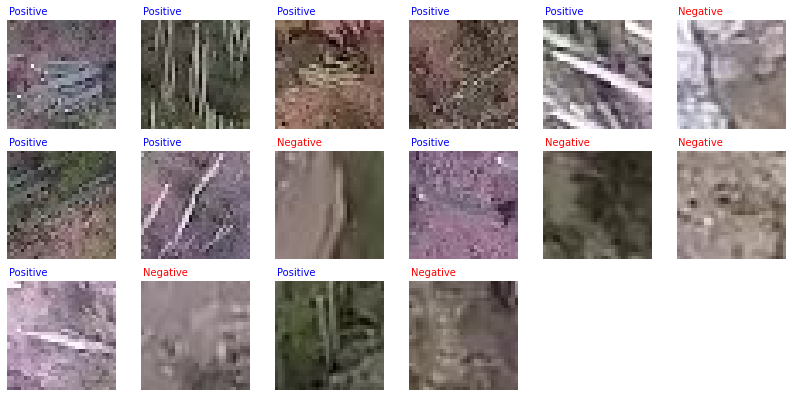

In [23]:
import matplotlib.pyplot as plt
def training_images(seed):
    np.random.seed(seed)
    train_generator.reset()
    imgs, labels = next(train_generator)
    tr_labels = np.argmax(labels, axis=1)
    
    plt.figure(figsize=(14,14))
    for i in range(16):
        text_class = labels[i]
        plt.subplot(6,6,i+1)
        plt.imshow(imgs[i,:,:,:])
        if(text_class[0] == 1):
            plt.text(0, -2, 'Negative', color='r')
        else:
            plt.text(0, -2, 'Positive', color='b')
        plt.axis('off')
    plt.show()
    
    
training_images(2)

### 2.1 VGG19

In [83]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,ZeroPadding2D,Dropout
from tensorflow.keras.applications import VGG19

In [84]:
model = VGG19(weights= None,include_top=True,input_shape=(32,32,3),classes=2,classifier_activation="softmax")

In [85]:
#to freeze some layer
for layer in model.layers[:6]:
    layer.trainable = False

In [86]:
for layer in model.layers:
    sp=' '[len(layer.name):]
    print(layer.name,sp,layer.trainable)

input_7  False
block1_conv1  False
block1_conv2  False
block1_pool  False
block2_conv1  False
block2_conv2  False
block2_pool  True
block3_conv1  True
block3_conv2  True
block3_conv3  True
block3_conv4  True
block3_pool  True
block4_conv1  True
block4_conv2  True
block4_conv3  True
block4_conv4  True
block4_pool  True
block5_conv1  True
block5_conv2  True
block5_conv3  True
block5_conv4  True
block5_pool  True
flatten  True
fc1  True
fc2  True
predictions  True


In [87]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [88]:
history = model.fit_generator(train_generator,
                         steps_per_epoch = len(train_generator),
                         epochs = 20,
                         validation_data = valid_generator,
                         validation_steps = len(valid_generator),
                         verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
192/192 [==============================] - 11s 51ms/step - loss: 0.5898 - accuracy: 0.7302 - val_loss: 0.5788 - val_accuracy: 0.7453
Epoch 2/20
192/192 [==============================] - 10s 50ms/step - loss: 0.5665 - accuracy: 0.7490 - val_loss: 0.5703 - val_accuracy: 0.7453
Epoch 3/20
192/192 [==============================] - 9s 49ms/step - loss: 0.5629 - accuracy: 0.7508 - val_loss: 0.5677 - val_accuracy: 0.7453
Epoch 4/20
192/192 [==============================] - 10s 50ms/step - loss: 0.5621 - accuracy: 0.7511 - val_loss: 0.5676 - val_accuracy: 0.7453
Epoch 5/20
192/192 [==============================] - 9s 49ms/step - loss: 0.5580 - accuracy: 0.7551 - val_loss: 0.5686 - val_accuracy: 0.7453
Epoch 6/20
192/192 [==============================] - 9s 49ms/step - loss: 0.5633 - accuracy: 0.7509 - val_loss: 0.5675 - val_accuracy: 0.7453
Epoch 7/20
192/192 [==============================] - 10s 49ms/step - loss: 0.5547 - accuracy: 0.7578 - val_loss: 0.5681 - val_accuracy: 0.

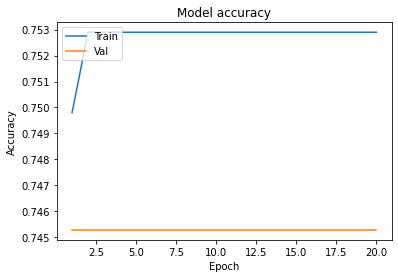

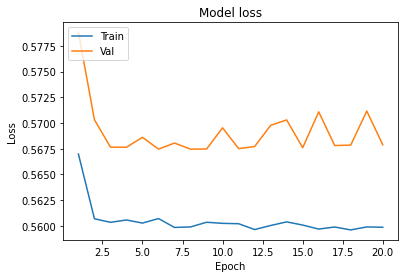

In [89]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(history, 20)

### 2.2 ResNet50

In [57]:
from tensorflow.keras.applications import ResNet50

In [61]:
model = ResNet50(weights= None,include_top=True,input_shape=(32,32,3),classes=2,classifier_activation="softmax")

In [74]:
#to freeze some layer
for layer in model.layers[:25]:
    layer.trainable = False

In [75]:
for layer in model.layers:
    sp=' '[len(layer.name):]
    print(layer.name,sp,layer.trainable)

input_6  False
conv1_pad  False
conv1_conv  False
conv1_bn  False
conv1_relu  False
pool1_pad  False
pool1_pool  False
conv2_block1_1_conv  False
conv2_block1_1_bn  False
conv2_block1_1_relu  False
conv2_block1_2_conv  False
conv2_block1_2_bn  False
conv2_block1_2_relu  False
conv2_block1_0_conv  False
conv2_block1_3_conv  False
conv2_block1_0_bn  False
conv2_block1_3_bn  False
conv2_block1_add  False
conv2_block1_out  False
conv2_block2_1_conv  False
conv2_block2_1_bn  False
conv2_block2_1_relu  False
conv2_block2_2_conv  False
conv2_block2_2_bn  False
conv2_block2_2_relu  False
conv2_block2_3_conv  True
conv2_block2_3_bn  True
conv2_block2_add  True
conv2_block2_out  True
conv2_block3_1_conv  True
conv2_block3_1_bn  True
conv2_block3_1_relu  True
conv2_block3_2_conv  True
conv2_block3_2_bn  True
conv2_block3_2_relu  True
conv2_block3_3_conv  True
conv2_block3_3_bn  True
conv2_block3_add  True
conv2_block3_out  True
conv3_block1_1_conv  True
conv3_block1_1_bn  True
conv3_block1_1_relu

In [76]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [77]:
history = model.fit_generator(train_generator,
                         steps_per_epoch = len(train_generator),
                         epochs = 10,
                         validation_data = valid_generator,
                         validation_steps = len(valid_generator),
                         verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
192/192 [==============================] - 18s 73ms/step - loss: 0.0240 - accuracy: 0.9932 - val_loss: 0.0579 - val_accuracy: 0.9857
Epoch 2/10
192/192 [==============================] - 13s 68ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0437 - val_accuracy: 0.9909
Epoch 3/10
192/192 [==============================] - 13s 68ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0501 - val_accuracy: 0.9870
Epoch 4/10
192/192 [==============================] - 13s 69ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0454 - val_accuracy: 0.9905
Epoch 5/10
192/192 [==============================] - 13s 68ms/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0532 - val_accuracy: 0.9916
Epoch 6/10
192/192 [==============================] - 13s 68ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0502 - val_accuracy: 0.9893
Epoch 7/10
192/192 [==============================] - 13s 69ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.0470 - val_accuracy:

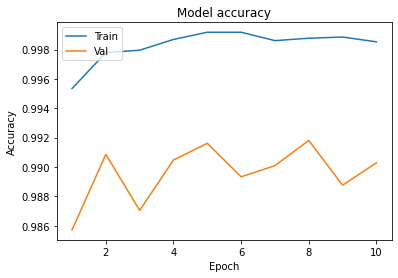

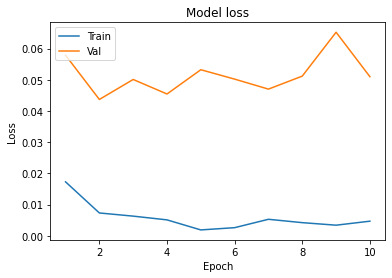

In [81]:

import matplotlib.pyplot as plt
def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(history, 10)